In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
import warnings
from tqdm import tqdm
%matplotlib inline

In [2]:
def class_spitter(df):
    classes = np.unique(df.classification_system)
    cellarray = []
    for i in range(len(classes)):
        new = df.query(f"classification_system in @classes[{i}]")
        cellarray.append(new)
    return cellarray

def type_spitter(df):
    types = np.unique(df.cell_type)
    cellarray = []
    for i in range(len(types)):
        new = df.query(f"cell_type in @types[{i}]")
        cellarray.append(new)
    return cellarray

In [3]:
def Eucdistance_split(pre,post):
    x_pre,y_pre,z_pre = np.array(pre.pt_position_x)*4,np.array(pre.pt_position_y)*4,np.array(pre.pt_position_z)*40
    x_pos,y_pos,z_pos = np.array(post.pt_position_x)*4,np.array(post.pt_position_y)*4,np.array(post.pt_position_z)*40
    d = np.zeros(len(post))
    for i in range(len(post)):
        # divide by 1000 to convert to microns
        d[i] = np.sqrt((x_pre-x_pos[i])**2 + (y_pre-y_pos[i])**2 + (z_pre-z_pos[i])**2) / 1000.
    return d

def Raddistance_split(pre,post):
    x_pre,z_pre = np.array(pre.pt_position_x)*4,np.array(pre.pt_position_z)*40
    x_pos,z_pos = np.array(post.pt_position_x)*4,np.array(post.pt_position_z)*40
    d = np.zeros(len(post))
    for i in range(len(post)):
        # divide by 1000 to convert to microns
        d[i] = np.sqrt((x_pre-x_pos[i])**2 + (z_pre-z_pos[i])**2) / 1000.
    return d

In [4]:
client = CAVEclient(global_only=True)
# https://annotationframeworkclient.readthedocs.io/en/stable/guide/authentication.html#new-token
client = CAVEclient('minnie65_phase3_v1')
client.info.get_datastack_info()

{'description': 'This is the first version of Minnie that has proofreading enabled. Was first enabled on June 24, 2020. ',
 'analysis_database': None,
 'aligned_volume': {'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/microns/minnie/minnie65-phase3-em/aligned/v1',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'name': 'minnie65_phase3',
  'id': 1},
 'local_server': 'https://minnie.microns-daf.com',
 'synapse_table': 'synapses_pni_2',
 'viewer_site': 'http://neuromancer-seung-import.appspot.com/',
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1',
 'soma_table': 'nucleus_neuron_svm'}

In [5]:
#client.materialize.get_tables()

In [6]:
df = client.materialize.query_table('allen_v1_column_types_slanted',split_positions=True)
print(len(df))
df[0:1]

1355


/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,valid,classification_system,cell_type,pt_position_x,pt_position_y,pt_position_z,pt_supervoxel_id,pt_root_id
0,2,t,aibs_coarse_excitatory,6P,195744,241616,22156,91714732578520135,864691135969106021


In [7]:
# start cell
root_id = [864691135428608048]
boy = df.query("pt_root_id in @root_id")
# post-synaptic partners of starter cell
syn_unfiltered = client.materialize.query_table('synapses_pni_2',filter_equal_dict={'pre_pt_root_id':root_id[0]})

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
unique_syn = np.unique(syn_unfiltered.post_pt_root_id)
print("There are {0:g} synaptic connections from {1:g} cells (unfiltered for mergers).".format(len(syn_unfiltered),len(unique_syn)))

There are 5551 synaptic connections from 2409 cells (unfiltered for mergers).


    Now to see how many of those cells are nuclei vs glial cells...

In [9]:
correct_soma_table = client.info.get_datastack_info()['soma_table']
nuclei_unmasked = client.materialize.query_table(correct_soma_table,split_positions=True)
# new df of just neurons (no glial cells)
nuclei = nuclei_unmasked.query('cell_type == "neuron"').reset_index(drop=True)
# new column saying how many neurons have the same root_id
nuclei['num_soma'] = nuclei.groupby('pt_root_id').transform('count')['valid']
# mask the df to throw out merged nuclei (same root_id being assigned to multiple neurons)
mask_nuclei = nuclei['num_soma'] < 2
nuclei_full = nuclei[mask_nuclei].reset_index(drop=True)

In [10]:
unique_nuc = np.unique(nuclei_full.pt_root_id)
soma_full = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1',filter_in_dict = {'pt_root_id':unique_nuc},
                                          split_positions=True)

In [11]:
print(len(soma_full))
soma_full[0:1]

59461


,id,valid,classification_system,cell_type,pt_position_x,pt_position_y,pt_position_z,pt_supervoxel_id,pt_root_id
0,137038,t,aibs_coarse_excitatory,5P_NP,108112,263424,22009,79684632194875255,864691134784325628


In [12]:
syn_nuc = syn_unfiltered.query("post_pt_root_id in @unique_nuc").reset_index(drop=True)

In [13]:
syn_nuc['num_syn'] = syn_nuc.groupby('post_pt_root_id').transform('count')['valid']
print(len(syn_nuc))
syn_nuc[0:1]

4220


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,num_syn
0,163776283,t,90008221812671631,864691135428608048,90008221812657455,864691135428664368,2016,"[183508, 110188, 22121]","[183440, 110198, 22110]","[183515, 110251, 22112]",9


In [14]:
syn_nuc.rename(columns={'post_pt_root_id':'pt_root_id'}, inplace=True)

In [15]:
main_duplicates = pd.merge(soma_full,syn_nuc,on='pt_root_id',how='outer')[0:61847] # any cells after 61847 are not in the soma table
new_left = pd.merge(soma_full,syn_nuc,on='pt_root_id',how='left')
main = new_left.drop_duplicates(subset='pt_root_id', keep='first').reset_index(drop=True)
# groupby('pt_root_id') ag function, list synapse positions

In [16]:
main = main.drop(columns=['valid_y', 'pre_pt_supervoxel_id', 'post_pt_supervoxel_id', 'pre_pt_position', 'post_pt_position'])

In [17]:
main['pre_pt_root_id'] = main['pre_pt_root_id'].fillna(0)
main['num_syn'] = main['num_syn'].fillna(0)
# might want to grab total size of all synapses for post-syn

In [18]:
#weird = [864691136311986237]
#new_outer.query('pt_root_id in @weird')

In [19]:
#good = [864691134884758266]
#new_outer.query('pt_root_id in @good')

In [20]:
main['d'] = Eucdistance_split(boy,main)
main['r'] = Raddistance_split(boy,main)

In [21]:
main[0:1]

,id_x,valid_x,classification_system,cell_type,pt_position_x,pt_position_y,pt_position_z,pt_supervoxel_id,pt_root_id,id_y,pre_pt_root_id,size,ctr_pt_position,num_syn,d,r
0,137038,t,aibs_coarse_excitatory,5P_NP,108112,263424,22009,79684632194875255,864691134784325628,NaN,0.0,NaN,NaN,0.0,589.973893,291.559407


In [22]:
unique_syn_nuc = np.unique(syn_nuc.pt_root_id)
syn = main.query('pt_root_id in @unique_syn_nuc')
nonsyn = main.query('pt_root_id not in @unique_syn_nuc')

In [23]:
syn_class = class_spitter(syn)
nonsyn_class = class_spitter(nonsyn)

# TIME TO PLOT

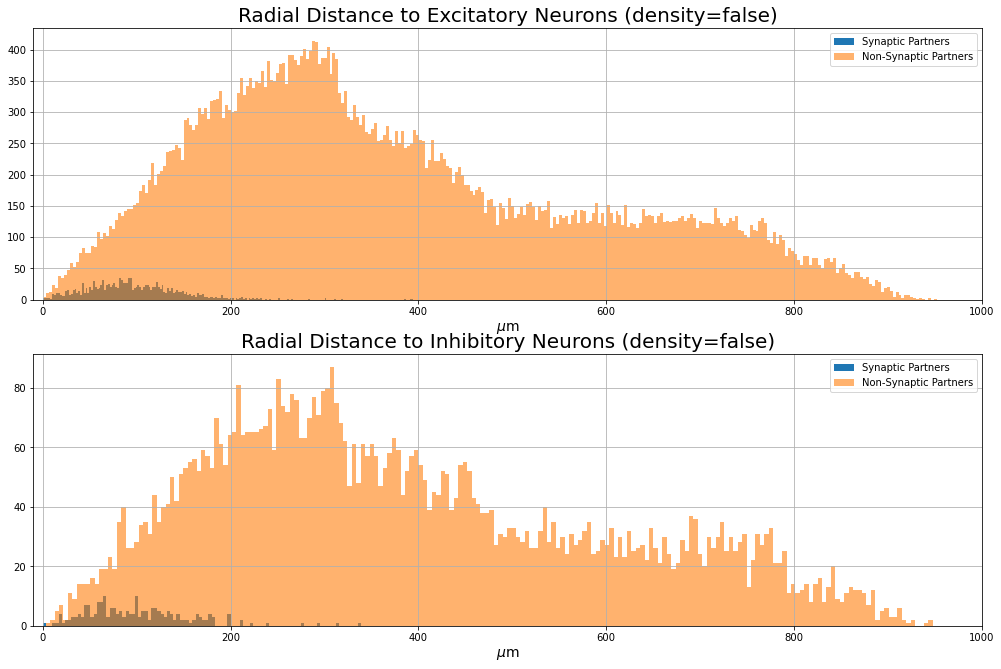

In [24]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(17,11)

ax[0].hist(syn_class[0]['r'], 200, label='Synaptic Partners', density=False, alpha=1.0)
ax[0].hist(nonsyn_class[0]['r'], 300, label='Non-Synaptic Partners', density=False, alpha=0.6)
ax[0].set_title("Radial Distance to Excitatory Neurons (density=false)", fontsize=20)
ax[0].set_xlabel(r'$\mu$m', fontsize=14)
ax[0].legend()
ax[0].grid()

ax[1].hist(syn_class[1]['r'], 100, label='Synaptic Partners', density=False, alpha=1.0)
ax[1].hist(nonsyn_class[1]['r'], 200, label='Non-Synaptic Partners', density=False, alpha=0.6)
ax[1].set_title("Radial Distance to Inhibitory Neurons (density=false)", fontsize=20)
ax[1].set_xlabel(r'$\mu$m', fontsize=14)
ax[1].legend()
ax[1].grid()

ax[0].set_xlim(-10,1000)
ax[1].set_xlim(-10,1000)
plt.show()

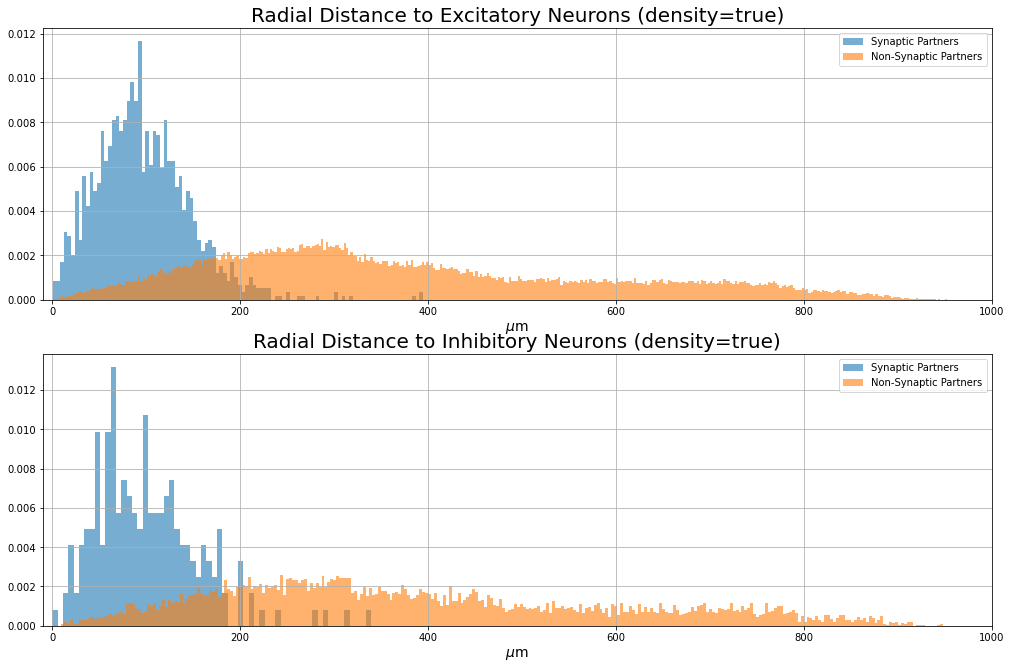

In [25]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(17,11)

ax[0].hist(syn_class[0]['r'], 100, label='Synaptic Partners', density=True, alpha=0.6)
ax[0].hist(nonsyn_class[0]['r'], 400, label='Non-Synaptic Partners', density=True, alpha=0.6)
ax[0].set_title("Radial Distance to Excitatory Neurons (density=true)", fontsize=20)
ax[0].set_xlabel(r'$\mu$m', fontsize=14)
ax[0].legend()
ax[0].grid()

ax[1].hist(syn_class[1]['r'], 60, label='Synaptic Partners', density=True, alpha=0.6)
ax[1].hist(nonsyn_class[1]['r'], 300, label='Non-Synaptic Partners', density=True, alpha=0.6)
ax[1].set_title("Radial Distance to Inhibitory Neurons (density=true)", fontsize=20)
ax[1].set_xlabel(r'$\mu$m', fontsize=14)
ax[1].legend()
ax[1].grid()

ax[0].set_xlim(-10,1000)
ax[1].set_xlim(-10,1000)
plt.show()

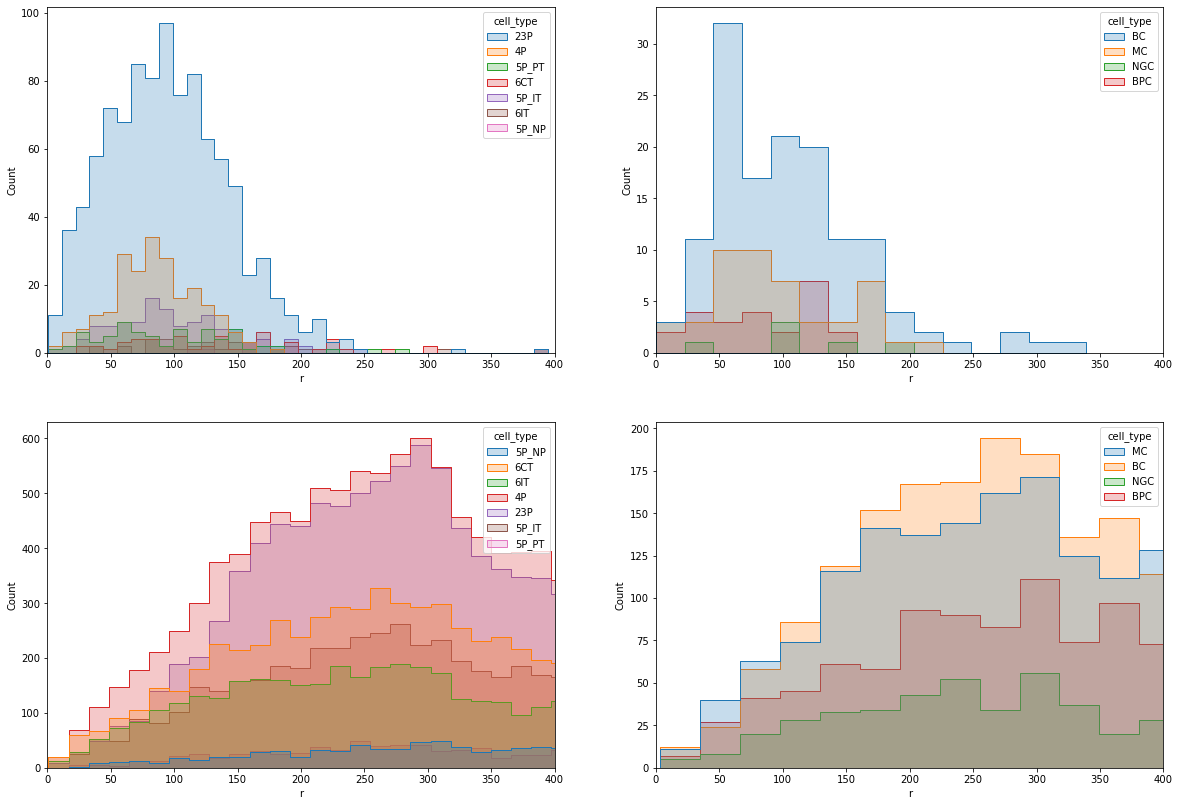

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

sns.histplot(data=syn_class[0], x="r", hue='cell_type', element='step', ax=axs[0,0]).set(xlim=(0,400));
sns.histplot(data=syn_class[1], x="r", hue='cell_type', element='step', ax=axs[0,1]).set(xlim=(0,400));
sns.histplot(data=nonsyn_class[0], x="r", hue='cell_type', element='step', ax=axs[1,0]).set(xlim=(0,400));
sns.histplot(data=nonsyn_class[1], x="r", hue='cell_type', element='step', ax=axs[1,1]).set(xlim=(0,400));

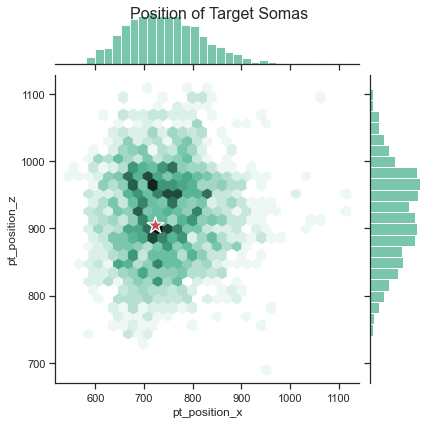

In [27]:
sns.set_theme(style="ticks")

bap = sns.jointplot(x=syn.pt_position_x*(4/1000), 
              y=syn.pt_position_z*(40/1000), 
              kind='hex',color="#4CB391", height=6)#, marginal_kws=dict(bins=35, fill=False))

sns.scatterplot(x=boy.pt_position_x*(4/1000),
               y=boy.pt_position_z*(40/1000),
               marker='*',color='r',s=300)#.set_title("Position of Target Somas", fontsize=16)
bap.fig.suptitle("Position of Target Somas", fontsize=16)
fig.tight_layout()

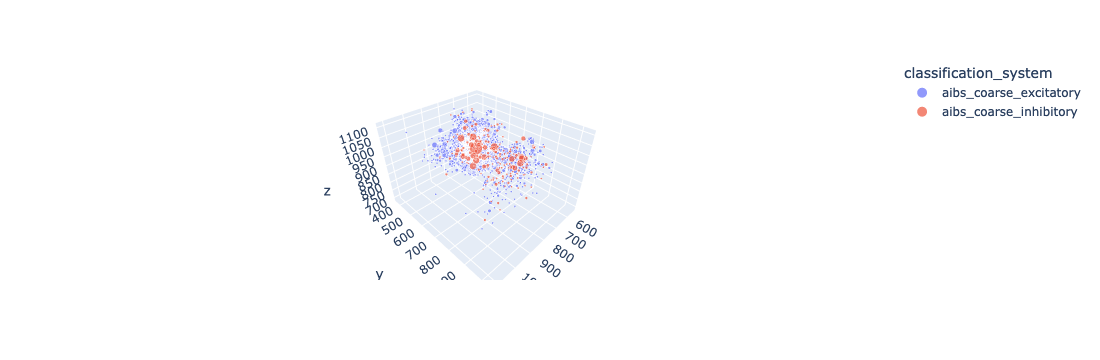

In [38]:
import plotly_express as px

x = syn['pt_position_x'] * (4/1000)
y = syn['pt_position_y'] * (4/1000)
z = syn['pt_position_z'] * (40/1000)

bep = px.scatter_3d(syn, x=x, y=y, z=z,
              color='classification_system', size='num_syn')
#px.scatter_3d(boy,x=boy.pt_position_x/4,y=boy.pt_position_y/4,z=boy.pt_position_z/40,symbol='pt_root_id')
bep.show()

In [39]:
# big 3D boy, messy

x_main = main['pt_position_x'] * (4/1000)
y_main = main['pt_position_y'] * (4/1000)
z_main = main['pt_position_z'] * (40/1000)

g = px.scatter_3d(main, x=x_main, y=y_main, z=z_main,
              color='pre_pt_root_id', opacity=.1, range_color = [0,1], size=np.ones(len(main)))

#g.show()

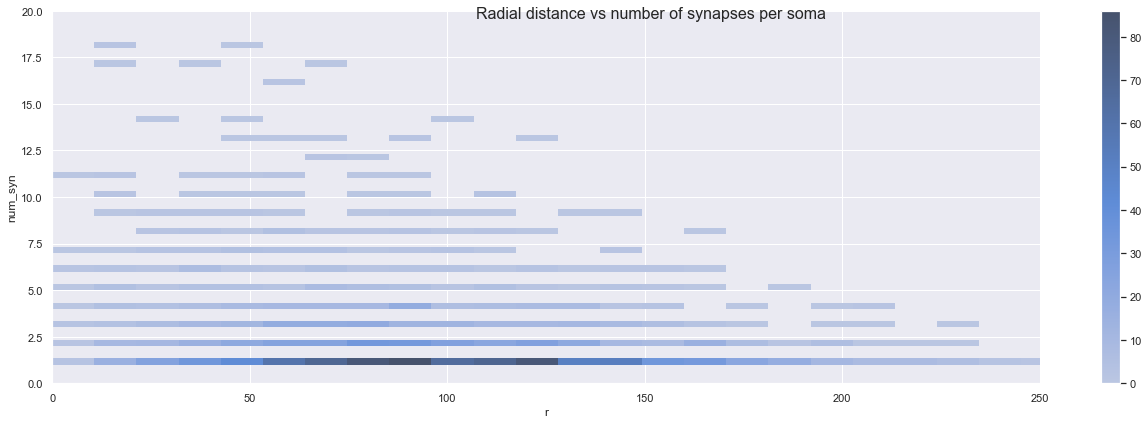

In [29]:
#, binwidth=(2, .5)
beep = sns.displot(syn, x='r', y='num_syn', cbar=True, height=6, aspect=3);
beep.set(xlim=(0, 250));
beep.set(ylim=(0, 20));
beep.fig.suptitle('Radial distance vs number of synapses per soma', fontsize=16);

# EXAMINING DEPTH

In [30]:
L1 = [296,400]
L23 = [401,588]
L4 = [589,736]
L5 = [736,896]
L6 = [897,1060]
WM = [1061,1146]
depths = np.array((L1,L23,L4,L5,L6,WM))
depth_names = np.array(('L1','L23','L4','L5','L6','WM'))

In [31]:
depth_syn,depth_nonsyn = [],[]
for i in range(len(depths)):
    m1 = syn[((syn['pt_position_y']*(4/1000)) < depths[i][1]) & ((syn['pt_position_y']*(4/1000)) > depths[i][0])].reset_index(drop=True)
    m2 = nonsyn[((nonsyn['pt_position_y']*(4/1000)) < depths[i][1]) & ((nonsyn['pt_position_y']*(4/1000)) > depths[i][0])].reset_index(drop=True)
    depth_syn.append(m1)
    depth_nonsyn.append(m2)

In [32]:
# the scraps of my failed animation... might be revived eventually...

# fig, ax = plt.subplots()
# #fig = plt.figure(figsize=(6,6))
# #ax = plt.axes(xlim=(500, 900), ylim=(700, 1100))
# fig.set_size_inches(6,6)

# def init(): 
#     xsyn,ysyn=depth_syn[0].pt_position_x*(4/1000),depth_syn[0].pt_position_z*(40/1000) 
#     xnon,ynon=depth_nonsyn[0].pt_position_x*(4/1000),depth_nonsyn[0].pt_position_z*(40/1000) 
#     scatsyn = sns.scatterplot(xsyn,ysyn,c='blue',alpha=.8)
#     scatnon = sns.scatterplot(xnon,ynon,alpha=.4)
#     return scatnon,scatsyn

# def animate(i):       
#     xsyn,ysyn=depth_syn[i].pt_position_x*(4/1000),depth_syn[i].pt_position_z*(40/1000) 
#     xnon,ynon=depth_nonsyn[i].pt_position_x*(4/1000),depth_nonsyn[i].pt_position_z*(40/1000) 
#     scatsyn = ax.scatter(xsyn,ysyn,c='blue',alpha=.8,s=200)
#     scatnon = ax.scatter(xnon,ynon,c='grey',alpha=.4,s=200)
#     print(i)
#     return scatnon,scatsyn

# animation.FuncAnimation(fig=fig, func=animate, frames=5, interval=800);
#plt.show()


# ax.set(xlim=(-3, 3), ylim=(-1, 1))
# scat = ax.scatter(x[::3], F[0, ::3])
 
# def animate(i):
#     y_i = F[i, ::3]
#     scat.set_offsets(np.c_[x[::3], y_i])

#Note the set_offsets must be passed an N×2 array. 
#Here we use np.c_[] for this purpose. 
#The use of [::3] reduces the density of scatter points.

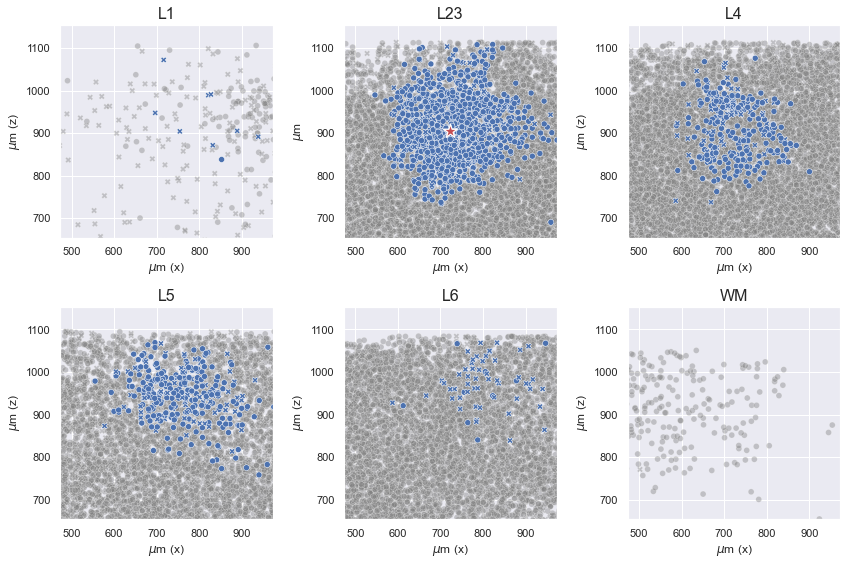

In [33]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)

#weight = syn.eval("num_syn / 40").rename("weight")
for i in range(len(depths)):
    if i < 3:
        sns.scatterplot(data=depth_nonsyn[i], x=depth_nonsyn[i].pt_position_x*(4/1000), y=depth_nonsyn[i].pt_position_z*(40/1000),
                       ax=ax[0,i], color='grey', style = 'classification_system', alpha=.4, legend= False).set_ylabel(r'$\mu$m (z)')
        sns.scatterplot(data=depth_syn[i], x=depth_syn[i].pt_position_x*(4/1000), y=depth_syn[i].pt_position_z*(40/1000),
                       ax=ax[0,i], color='b', style = 'classification_system', alpha=1., legend= False).set_xlabel(r'$\mu$m (x)')
        sns.scatterplot(x=boy.pt_position_x*(4/1000), y=boy.pt_position_z*(40/1000), marker='*',color='r',s=200,
                        ax=ax[0,1], legend= False).set_ylabel(r'$\mu$m')
        xrange = [int(boy.pt_position_x*(4/1000))-250,int(boy.pt_position_x*(4/1000))+250]
        yrange = [int(boy.pt_position_z*(40/1000))-250,int(boy.pt_position_z*(40/1000))+250]
        ax[0,i].set_xlim(xrange[0],xrange[1])
        ax[0,i].set_ylim(yrange[0],yrange[1])
        ax[0,i].set_title(depth_names[i],fontsize=16)
        ax[0,i].set_aspect('equal')
    else:
        sns.scatterplot(data=depth_nonsyn[i], x=depth_nonsyn[i].pt_position_x*(4/1000), y=depth_nonsyn[i].pt_position_z*(40/1000),
                       ax=ax[1,i-3], color='grey', style = 'classification_system', alpha=.4, legend= False).set_ylabel(r'$\mu$m (z)')
        sns.scatterplot(data=depth_syn[i], x=depth_syn[i].pt_position_x*(4/1000), y=depth_syn[i].pt_position_z*(40/1000),
                       ax=ax[1,i-3], color='b', style = 'classification_system', alpha=1., legend= False).set_xlabel(r'$\mu$m (x)')
        #sns.scatterplot(x=boy.pt_position_x*(4/1000), y=boy.pt_position_z*(40/1000), marker='*',color='r',s=200,
                        #ax=ax[1,i-3]).set_ylabel(r'$\mu$m')
        xrange = [int(boy.pt_position_x*(4/1000))-250,int(boy.pt_position_x*(4/1000))+250]
        yrange = [int(boy.pt_position_z*(40/1000))-250,int(boy.pt_position_z*(40/1000))+250]
        ax[1,i-3].set_xlim(xrange[0],xrange[1])
        ax[1,i-3].set_ylim(yrange[0],yrange[1])
        ax[1,i-3].set_title(depth_names[i],fontsize=16)
        ax[1,i-3].set_aspect('equal')
fig.tight_layout()

In [34]:
#yvsr = sns.displot(x=syn.r, y=syn.pt_position_y*(4/1000), cbar=True, height=6, aspect=.9);
#yvsr.fig.suptitle('Radial distance vs depth of target soma', fontsize=16);

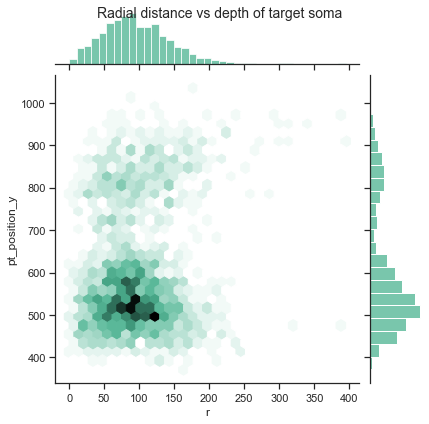

In [35]:
sns.set_theme(style="ticks")
yvsr = sns.jointplot(x=syn.r, 
              y=syn.pt_position_y*(4/1000), 
              kind='hex',color="#4CB391", height=6)
yvsr.fig.suptitle('Radial distance vs depth of target soma', fontsize=14);
fig.tight_layout()